# Warsztaty modelowania w nanofizyce
----
## Wizualizacja struktur atomowych i obliczenia z pierwszych zasad

**Paweł T. Jochym**

Zakład Komputerowych Badań Materiałów

Instytut Fizyki Jądrowej PAN, Kraków

Wszelkiego rodzaju wizualizacje sa niezwykle ważnym elaementem pracy badawczej. 
* Pozwalają na efektywną kontrolę poprawności obliczeń
* Ułatwiaja dostrzeżenie pojawiających się trendów/zjawisk
* Pozwalają na wydobycie trudnych do zauważenia zależności w wynikach
* Ułatwiają i czynią przystępnym przekaz zawarty w ostatecznej publikacji

Niestety także:
* Są czaso- i praco-chłonne 
* Wymagają umiejętnego wykonania aby zachować estetykę, czytelność
* Bywają mylące - niepostrzeżenie wzmacniając efekty o małej wadze 

In [2]:
# Import potrzebnych modułów
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from ase.build import bulk
from ase.build import graphene_nanoribbon
from ase.build import nanotube
from ase.build import surface
from ase.spacegroup import crystal
from ase import units
import ase.io
from IPython.core.display import Image
from ipywidgets import interact, interactive, fixed
from io import BytesIO
import tempfile
from __future__ import division, print_function
import nglview 

Poniższe ćwiczenia prezentują proste techniki tworzenia struktur atomowych (klastrów, kryształów, powierzchni) oraz wizualizacji uzyskanych układów. Istnieją liczne narzędzia służące do tego celu. Wiele z nich pozwala tworzyć wyrafinowane i piękne wizualizacje. Tutaj przedstawione są jedynie techniki możliwe do zastosowania w środowisku Jupyter na obecnym etapie jego rozwoju. Dokumentacja środowiska [Jupyter](https://jupyter.org/), języka [Python](https://python.org/), jego powłoki [IPython](https://ipython.org) oraz podstawowych używanych tutaj bibliotek znajduje się w menu Help powyżej oraz na stronach internetowych projektów. Funkcje dotyczące obliczeniowej fizyki materiałowej zawarte są w bibliotece [ASE](https://wiki.fysik.dtu.dk/ase/) - jej obszerna dokumentacja znajduje się na stronie projektu.

### Tworzenie struktury

Zdefiniowanie struktury wymaga podania jej składu atomowego oraz pozycji jej składników. W przypadku struktur krystalicznych powinniśmy także określić ich symeterię oraz rozmiar i rodzaj ich komórki elementarnej.

#### Diament
Diament posiada jedną z prostych struktur krystalicznych o wysokiej symetrii. System ASE udostępnia specjalizowane funkcje generujące tego rodzaju struktury. Dostępne są także procedury pozwalające na stworzenie dowolnej struktury krystalicznej o zadanej symetrii.

Wyświetlanie utworzonych struktur umożliwia, między innymi, biblioteka [NGLview](http://arose.github.io/nglview/dev/index.html)

In [3]:
diament=bulk(name='C', crystalstructure='diamond', a=4, cubic=True)

In [16]:
view = nglview.show_ase(diament)
view.add_unitcell(); view.camera='orthographic'; view.add_spacefill(); view.center()
view

In [5]:
view.update_spacefill(radiusType='covalent', scale=1.0)
view.parameters=dict(clipDist=-100)

In [6]:
view.update_spacefill(radiusType='covalent', scale=1.0, assembly='SUPERCELL')

In [7]:
view.clear_representations()
view.add_unitcell(); view.add_ball_and_stick()
view.update_ball_and_stick(radiusType='covalent', scale=0.4, assembly='UNITCELL')

### Zapis obrazu struktury na dysk i jego wyświetlenie 

In [8]:
ase.io.write('diament.png',       # Nazwa pliku
             diament,             # obiekt zawierający definicję struktury
             show_unit_cell=2,    # Rysowanie komórki elementarnej
             rotation='115y,15x', # Obrót 115st wokół osi Y i 15st wokół osi X
             scale=30)            # Skala

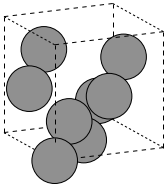

In [9]:
Image(filename='diament.png')

#### $\beta$-SiC
Nastęny przykład to kryształ $\beta$-SiC (węglika krzemu) o strukturze blendy cynkowej.

In [10]:
a=4.3596                                         # Stała sieci w Angstromach
SiC = crystal(['Si', 'C'],                       # Lista pierwiastków w krysztale
                [(0, 0, 0), (0.25, 0.25, 0.25)], # Pozycje atomów (jako ułamki stałych sieci)
                spacegroup=216,                  # Numer grupy symetrii (216 = Blenda Cynkowa = F-43m)
                cellpar=[a, a, a, 90, 90, 90])   # Komórka elementarna (a, b, c, alpha, beta, gamma)

### Wyświetlanie wyższej jakości

Biblioteka ASE pozwala na użycie zewnętrznego programu w celu uzyskania bardziej
widowiskowego obrazu struktury.

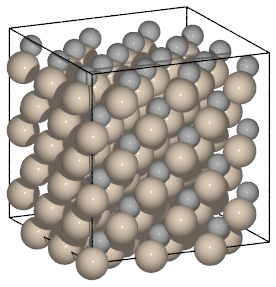

In [11]:
# Narysujmy większy fragment struktury
# Tym razem wyświetlony z użyciem zewnętrznego programu povray
bSiC=SiC.repeat(3)
ase.io.write('bSiC.pov', bSiC, show_unit_cell=2, rotation='115y,15x', run_povray=True)
Image(filename='bSiC.png')

### Bardziej złożone struktury

Biblioteka ASE udostępnia także funkcje wspomagające konstrukcję bardziej złożonych struktur: nanotaśm, nanorurek, powierzchni i wielu innych. Można także łatwo tworzyć struktury przy pomocy własnych procedur.

Aby sobie ułatwić życie zdefiniujemy własną funkcję wyświetlającą struktury:

In [12]:
def show_cryst(struct, uc=True):
    view = nglview.show_ase(struct)
    view.parameters=dict(clipDist=-100)
    if uc : view.add_unitcell()
    view.camera='orthographic'
    view.add_spacefill(radiusType='covalent', scale=0.5)
    view.center()
    return view  

In [13]:
# Nanotaśma grafitowa
gnr = graphene_nanoribbon(4, 12, type='zigzag', saturated=True)

show_cryst(gnr, uc=False)

In [14]:
# Nanorurka
cnt = nanotube(6, 6, length=12, bond=1.4)
show_cryst(cnt,uc=False)

In [15]:
# Powierzchnia (1,0,0) molibdenu
Mo = bulk('Mo', 'bcc', a=3.16, cubic=True)
s = surface(Mo, (1, 0, 0),3, vacuum=10)
show_cryst(s.repeat((5,5,1)))